# Cardiovascular Disease Dataset


---


## The objective is to predict whether or not individual has a cardiovascular disease.

**Dataset Information**

The data set consists of a total of 11 features. The target variable is a binary value indicating whether or not a cardiovascular disease is present in the subject. <br>

**Feature Information**

Age | Objective Feature | age | int (days) | <br>
Height | Objective Feature | height | int (cm) | <br>
Weight | Objective Feature | weight | float (kg) | <br>
Gender | Objective Feature | gender | categorical code | 1: Women, 2: Men |<br>
Systolic blood pressure | Examination Feature | ap_hi | int | <br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary |<br>
Alcohol intake | Subjective Feature | alco | binary |<br>
Physical activity | Subjective Feature | active | binary |<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |<br>

## 1. Import Dependencies


---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

## 2. Data pre-processing


---



### Import data

In [ ]:
# Load the data
df = pd.read_csv('cardio_train.csv', delimiter=';')
data = df.copy()

# each row is a set of 12 values separated by ';'
# first objective is to transform this into a dataframe with 1 value per cell

# drops the 'id' column, which is basically an index
data.drop([0], inplace=True)
print(data.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   
5   8  21914       1     151    67.0    120     80            2     2      0   

   alco  active  cardio  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  
5     0       0       0  


In [ ]:
# Print initial information about the dataset
print("Initial data shape:", data.shape)
print("\nColumns:", data.columns)
print("\nFirst few rows:")
print(data.head())

Initial data shape: (69999, 13)

Columns: Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

First few rows:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   
5   8  21914       1     151    67.0    120     80            2     2      0   

   alco  active  cardio  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  
5     0       0       0  


Basic Data Preprocessing

In [ ]:
# Basic preprocessing
if 'age' in data.columns:
    data['age'] = data['age'] // 365  # Convert age from days to years

In [ ]:
# Remove outliers in blood pressure readings
if 'ap_hi' in data.columns and 'ap_lo' in data.columns:
    data = data[(data['ap_hi'] <= 370) & (data['ap_hi'] >= 0) &
                (data['ap_lo'] <= 360) & (data['ap_lo'] >= 0)]

In [ ]:
# Prepare data for model training
X = data.drop(['id', 'cardio'], axis=1, errors='ignore')
y = data['cardio']

In [ ]:

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Exploratory Data Analysis


---



In [ ]:
# check target variable distribution
df['cardio'].value_counts()

0.0    34854
1.0    34146
Name: cardio, dtype: int64

### Age vs Number of Subjects with heart disease

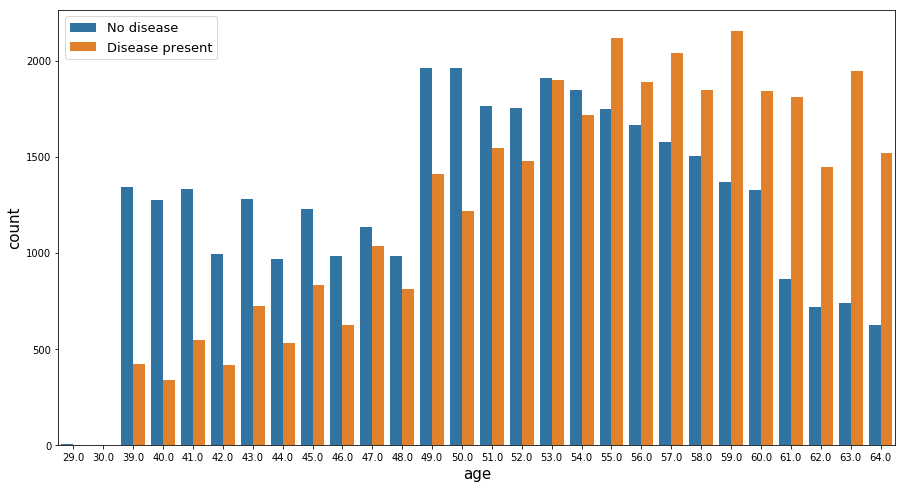

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(x='age', hue='cardio', data=df);

plt.ylabel('count', size=15)
plt.xlabel('age', size=15)

L = plt.legend(loc='upper left', prop={'size':13})
L.get_texts()[0].set_text('No disease')
L.get_texts()[1].set_text('Disease present')

In [ ]:
# split data into subjects with/without cardiovascular disease
dis = df[df['cardio'] == 1] # subjects with disease
no_dis = df[df['cardio'] == 0] # subjects without disease

In [ ]:
# group data by gender and cholesterol levels
# men with heart disease
dis_men_chol_1 = df[(df['gender'] == 2) & (df['cholesterol'] == 1)]
dis_men_chol_2 = df[(df['gender'] == 2) & (df['cholesterol'] == 2)]
dis_men_chol_3 = df[(df['gender'] == 2) & (df['cholesterol'] == 3)]

# women with heart disease
dis_women_chol_1 = df[(df['gender'] == 1) & (df['cholesterol'] == 1)]
dis_women_chol_2 = df[(df['gender'] == 1) & (df['cholesterol'] == 2)]
dis_women_chol_3 = df[(df['gender'] == 1) & (df['cholesterol'] == 3)]


# calculate means
men_chol_avgs = [ dis_men_chol_1['ap_hi'].mean(), dis_men_chol_2['ap_hi'].mean(), dis_men_chol_3['ap_hi'].mean() ]
women_chol_avgs = [ dis_women_chol_1['ap_hi'].mean(), dis_women_chol_2['ap_hi'].mean(), dis_women_chol_3['ap_hi'].mean() ]

### Systolic BP vs Cholesterol

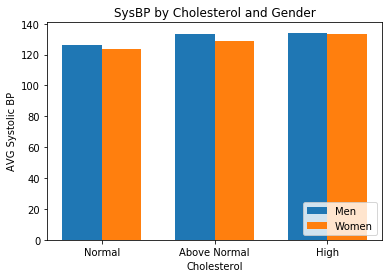

In [ ]:
ind = np.arange(len(men_chol_avgs))
width = .35

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, men_chol_avgs, width, label='Men')
rects2 = ax.bar(ind + width/2, women_chol_avgs, width, label='Women')

ax.set_ylabel('AVG Systolic BP')

ax.set_xlabel('Cholesterol')
ax.set_xticks(ind)
ax.set_xticklabels(('Normal', 'Above Normal', 'High'))

ax.legend(loc='lower right')
ax.set_title('SysBP by Cholesterol and Gender')
plt.show()

### Glucose in smokers vs non smokers

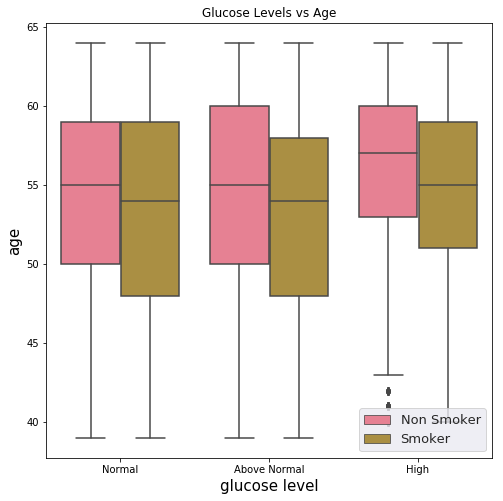

In [ ]:
plt.figure(figsize=(8, 8))
plt.title('Glucose Levels vs Age')

sns.set(style="dark", palette="husl", color_codes=True)

sns.boxplot(x="gluc", y="age", hue="smoke", data=dis)
L = plt.legend(loc='lower right', prop={'size':13})
L.get_texts()[0].set_text('Non Smoker')
L.get_texts()[1].set_text('Smoker')

plt.ylabel('age', size=15)
plt.xlabel('glucose level', size=15)

plt.xticks([0, 1, 2], ['Normal', 'Above Normal', 'High'])
plt.show()

### BP and Cholesterol distributions in individuals who are healthy vs individuals with disease

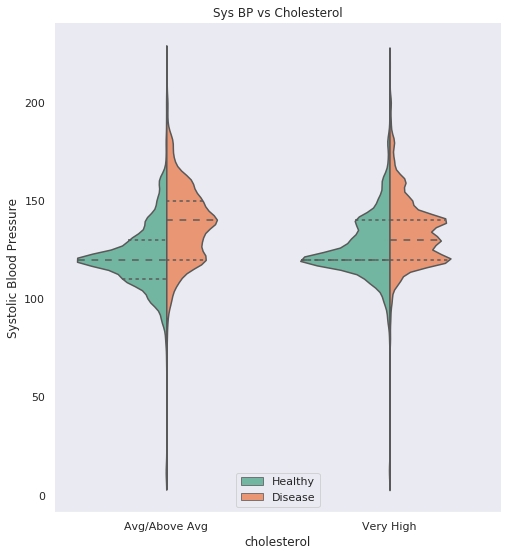

In [ ]:
df_high_chol = df[(df['cholesterol'] > 1) & (df['gluc'] > 1)]

plt.figure(figsize=(8,9))

sns.set(style="dark", palette="Set2", color_codes=True)

sns.violinplot(x="cholesterol", y="ap_hi", hue="cardio", split=True, inner="quart", data=df_high_chol)

plt.xticks([0, 1], ['Avg/Above Avg', 'Very High'])
plt.ylabel('Systolic Blood Pressure')

L = plt.legend(loc='lower center')
L.get_texts()[0].set_text('Healthy')
L.get_texts()[1].set_text('Disease')

plt.title('Sys BP vs Cholesterol')

sns.despine(left=True)

## Model Building

In [ ]:
# Model 1: Simple NN with default optimizer
model1 = create_model()

# Train the model
history1 = model1.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
1510/1510 [==============================] - 9s 4ms/step - loss: 0.5562 - accuracy: 0.7254 - val_loss: 0.5592 - val_accuracy: 0.7238
Epoch 2/50
1510/1510 [==============================] - 7s 4ms/step - loss: 0.5463 - accuracy: 0.7320 - val_loss: 0.5549 - val_accuracy: 0.7224
Epoch 3/50
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5438 - accuracy: 0.7338 - val_loss: 0.5567 - val_accuracy: 0.7241
Epoch 4/50
1510/1510 [==============================] - 11s 7ms/step - loss: 0.5427 - accuracy: 0.7347 - val_loss: 0.5526 - val_accuracy: 0.7230
Epoch 5/50
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5418 - accuracy: 0.7353 - val_loss: 0.5513 - val_accuracy: 0.7281
Epoch 6/50
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5405 - accuracy: 0.7358 - val_loss: 0.5592 - val_accuracy: 0.7265
Epoch 7/50
1510/1510 [==============================] - 7s 5ms/step - loss: 0.5398 - accuracy: 0.7348 - val_loss: 0.5550 - val_accuracy

In [ ]:
# Evaluate the model on test set
test_loss1, test_accuracy1 = model1.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Model 1 - Test accuracy: {test_accuracy1:.4f}")

Model 1 - Test accuracy: 0.7353


## Model 2:  NN with optimization techniques

In [ ]:
# Model 2: NN with multiple optimization techniques
def create_optimized_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model2 = create_optimized_model()

In [ ]:
# Learning Rate Scheduling
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the optimized model
history2 = model2.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,  # Increased epochs, early stopping will prevent overfitting
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/100
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5480 - accuracy: 0.7335 - val_loss: 0.5506 - val_accuracy: 0.7291 - lr: 0.0010
Epoch 2/100
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5476 - accuracy: 0.7326 - val_loss: 0.5503 - val_accuracy: 0.7288 - lr: 0.0010
Epoch 3/100
1510/1510 [==============================] - 7s 4ms/step - loss: 0.5478 - accuracy: 0.7324 - val_loss: 0.5503 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 4/100
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5463 - accuracy: 0.7338 - val_loss: 0.5513 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 5/100
1510/1510 [==============================] - 7s 5ms/step - loss: 0.5466 - accuracy: 0.7339 - val_loss: 0.5517 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 6/100
1510/1510 [==============================] - 6s 4ms/step - loss: 0.5451 - accuracy: 0.7348 - val_loss: 0.5508 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 7/100
1510/1510 [=============================

## Error Analysis

Optimized Model - Test Loss: 0.5418
Optimized Model - Test Accuracy: 0.7359
324/324 [==============================] - 1s 4ms/step

Optimized Model - Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      5275
           1       0.74      0.70      0.72      5075

    accuracy                           0.74     10350
   macro avg       0.74      0.74      0.74     10350
weighted avg       0.74      0.74      0.74     10350


Optimized Model - Confusion Matrix:
[[4053 1222]
 [1511 3564]]

Optimized Model - F1 Score: 0.7228
Optimized Model - Specificity: 0.7683


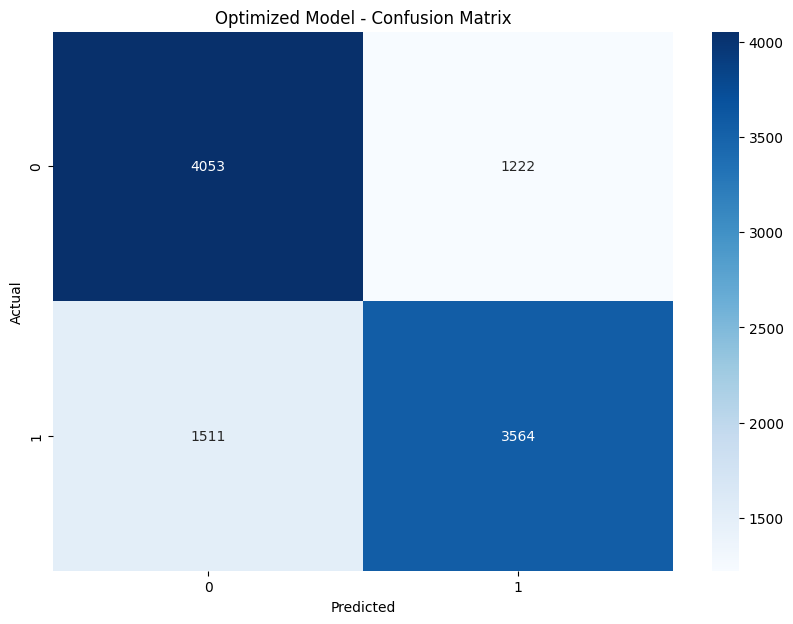

In [ ]:
# Evaluate the optimized model
test_loss2, test_accuracy2 = model2.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Optimized Model - Test Loss: {test_loss2:.4f}")
print(f"Optimized Model - Test Accuracy: {test_accuracy2:.4f}")

# Predict on the test set
y_pred_nn = (model2.predict(X_test_scaled) > 0.5).astype("int32")

# Generate the classification report
print("\nOptimized Model - Classification Report:")
print(classification_report(y_test, y_pred_nn))

# Generate the confusion matrix
nn_conf_matrix = confusion_matrix(y_test, y_pred_nn)
print("\nOptimized Model - Confusion Matrix:")
print(nn_conf_matrix)

# Calculate the F1 score
nn_f1_score = f1_score(y_test, y_pred_nn)
print(f"\nOptimized Model - F1 Score: {nn_f1_score:.4f}")

# Calculate Specificity (True Negative Rate)
tn, fp, fn, tp = nn_conf_matrix.ravel()
specificity = tn / (tn + fp)
print(f"Optimized Model - Specificity: {specificity:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(nn_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Optimized Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

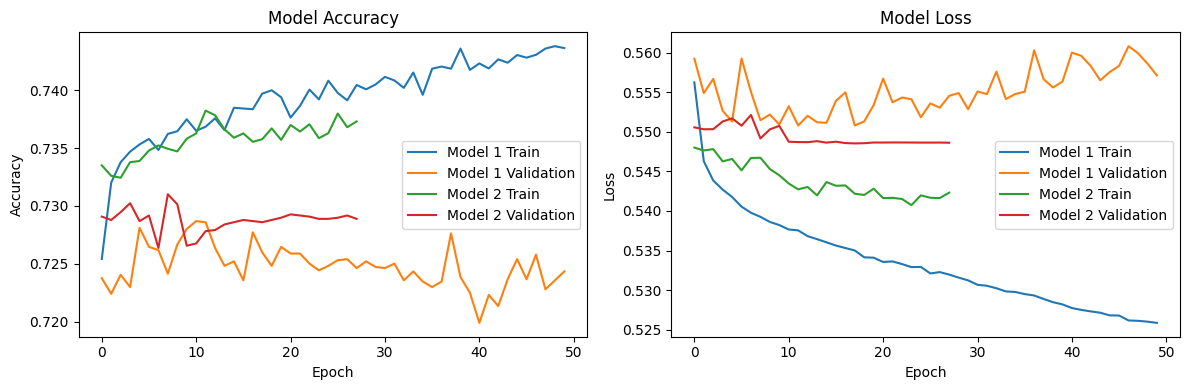

In [ ]:
# Plot training history for both models
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1 Train')
plt.plot(history1.history['val_accuracy'], label='Model 1 Validation')
plt.plot(history2.history['accuracy'], label='Model 2 Train')
plt.plot(history2.history['val_accuracy'], label='Model 2 Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Model 1 Train')
plt.plot(history1.history['val_loss'], label='Model 1 Validation')
plt.plot(history2.history['loss'], label='Model 2 Train')
plt.plot(history2.history['val_loss'], label='Model 2 Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import os

# Define the directory to save the models
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save Model 1 (Simple NN)
model1_path = os.path.join(save_dir, 'model1_simple_nn.h5')
model1.save(model1_path)
print(f"Model 1 (Simple NN) saved to {model1_path}")

# Save Model 2 (Optimized NN)
model2_path = os.path.join(save_dir, 'model2_optimized_nn.h5')
model2.save(model2_path)
print(f"Model 2 (Optimized NN) saved to {model2_path}")

Model 1 (Simple NN) saved to saved_models/model1_simple_nn.h5
Model 2 (Optimized NN) saved to saved_models/model2_optimized_nn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
